In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import itertools
import os
import imageio
from io import BytesIO
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from scipy import stats
from multiprocessing import Pool

from graph_generation import GenerateGraph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding
import experiments
from experiments import (Experiments, experiment_node_embedding, all_seeds)
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D_perclass,
                        plot_node_emb_nD_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_graph_emb_3D, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial_xp,
                        plot_onlyloss_ripetizioni_stesso_trial,
                        plot_onlyloss_ripetizioni_stesso_trial_superimposed)
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect
from config_valid import Config, TrainingMode
from GridConfigurations import GridConfigurations, open_df_results

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
import tensorflow as tf

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score, silhouette_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from plt_parameters import init_params
init_params()
#pd.set_option('display.height', 500)

rootsave = Path("output_plots/")

# ER con 6 classi

In [2]:
config_file = "configurations/classification2.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 9.941 p=0.05
Mean connectivity for each node: 19.893 p=0.1
Mean connectivity for each node: 59.757 p=0.3
Mean connectivity for each node: 79.55 p=0.4
Mean connectivity for each node: 99.538 p=0.5
Mean connectivity for each node: 119.442 p=0.6
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:13<00:00, 16.42it/s]


Tempo impiegato: 73.30954790115356


100%|███████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [06:49<00:00,  3.67it/s]


test accuracy finale: 0.3861111111111111


In [3]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[1]])
nodeembc2 = nodeembc2.squeeze()
nodeembc1 = nodeembc1.squeeze()
nodeembc1.shape, nodeembc2.shape

((200, 200, 2), (200, 200, 2))

In [93]:
#nodeembc1 = nodeembc1.reshape(-1,6)
#nodeembc2 = nodeembc2.reshape(-1,6)

In [94]:
#print(nodeembc1.T.shape)
#np.save('nodeembc1.npy', nodeembc1)
#np.save('nodeembc2.npy', nodeembc2)

(13, 15)


In [25]:
import umap
reducer = umap.UMAP()

In [38]:
embedding = reducer.fit_transform(nodeembc1)
embedding.shape


KeyboardInterrupt



In [6]:
res = [(embpergraph.node_label[0], embpergraph.graph_label, embpergraph.scalar_label) for classemb in embedding_class.emb_perclass for embpergraph in classemb]

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


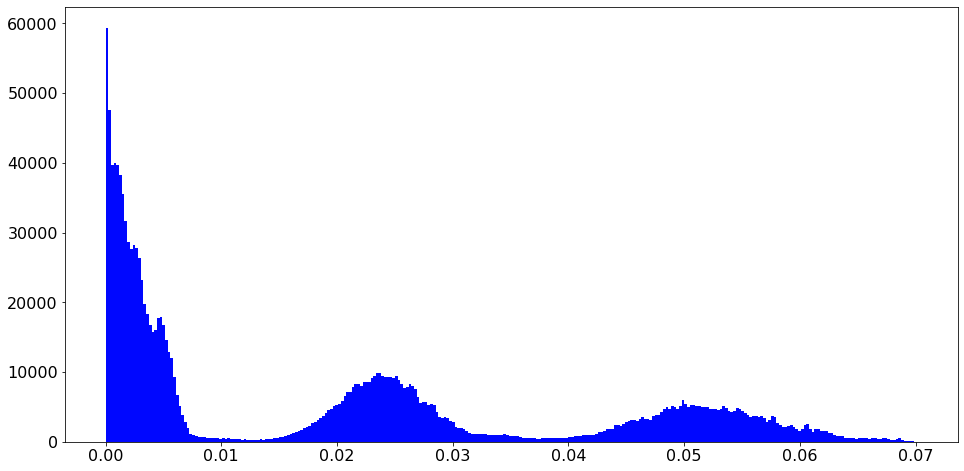

In [11]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)

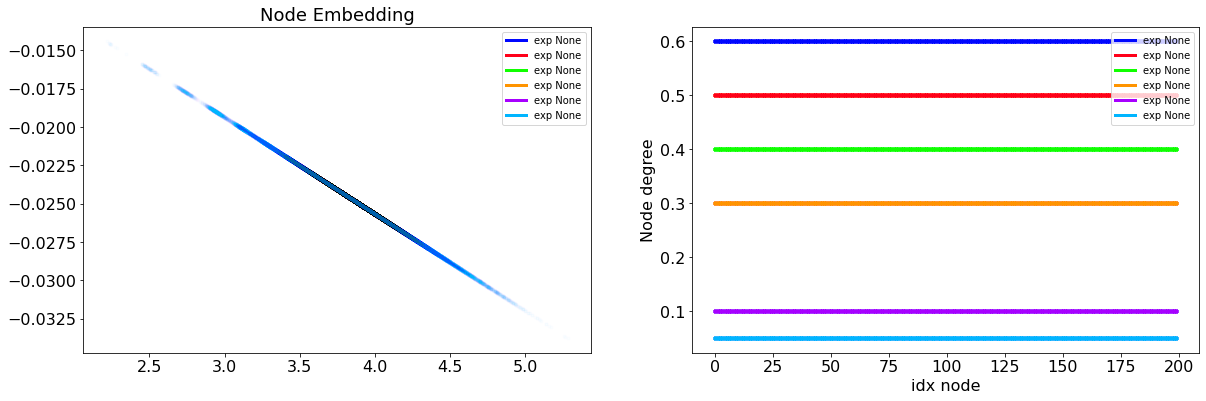

In [12]:
plot_node_emb_nD_perclass(embedding_class.emb_perclass)

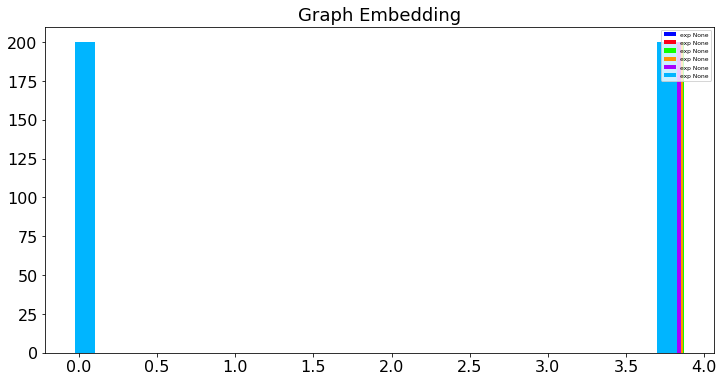

In [9]:
plot_graph_emb_1D(embedding_class.emb_perclass)

In [16]:
# best model test loss
xp.trainer.test(xp.trainer.dataset.test_loader)[0]

0.0008717531545294656

In [18]:
# best model accuracy
xp.trainer.accuracy(xp.trainer.dataset.test_loader)[0]

0.9305555555555556

### Tolgo i Linear layer finali

In [20]:
c = Config(config_file)
c.conf['model']['last_layer_dense'] = False
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 9.941 p=0.05
Mean connectivity for each node: 19.893 p=0.1
Mean connectivity for each node: 59.757 p=0.3
Mean connectivity for each node: 79.55 p=0.4
Mean connectivity for each node: 99.538 p=0.5
Mean connectivity for each node: 119.442 p=0.6
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:10<00:00, 17.12it/s]


Tempo impiegato: 70.29792785644531


100%|███████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [06:46<00:00,  3.69it/s]


test accuracy finale: 0.7861111111111111


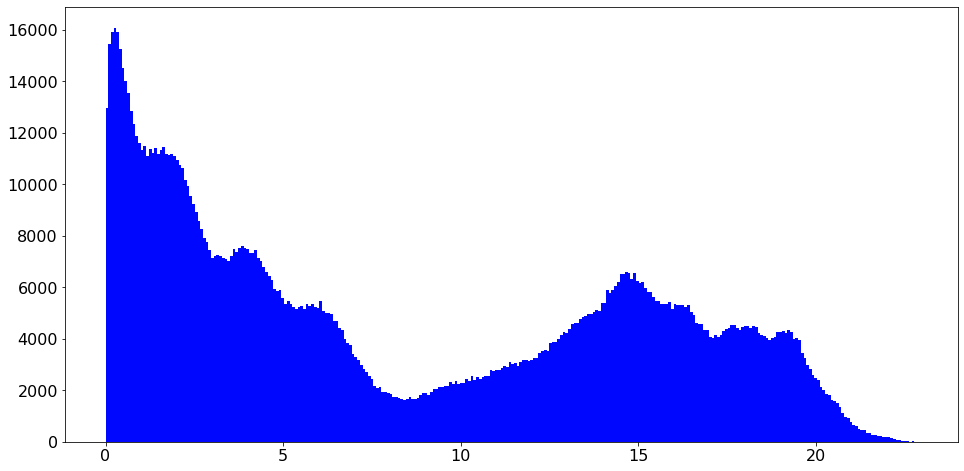

In [21]:
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class, num_emb_neurons, xp.trainer.config_class.modo)

In [39]:
embedding_class.emb_perclass[0][0].node_embedding_array.shape

(200, 6)

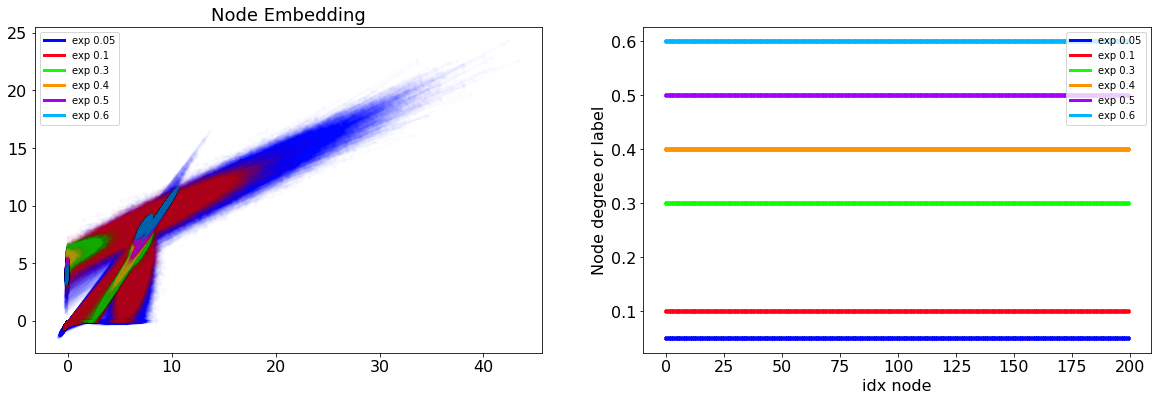

In [41]:
plot_node_emb_nD_perclass(embedding_class.emb_perclass)

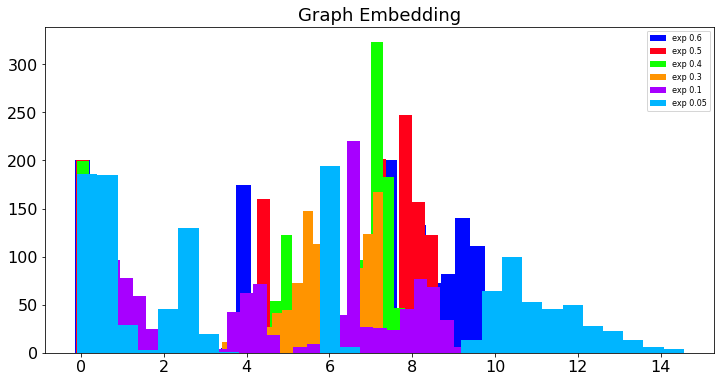

In [44]:
plot_graph_emb_1D(embedding_class.emb_perclass)

# Embedding perturbations

In [2]:
config_file = "configurations/ER_embed_perturb.yml"

### GCN trainable

### Tolgo i Linear layer finali

In [4]:
c = Config(config_file)
c.conf['model']['last_layer_dense'] = False
xp1 = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp1.just_train()
embedding_class_nolinear = xp1.embedding()

Generating dataset...
Mean connectivity for each node: 9.955 p=0.05
Mean connectivity for each node: 59.707 p=0.3
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.11it/s]


Tempo impiegato: 6.450821161270142


100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:32<00:00, 24.62it/s]

test accuracy finale: 1.0


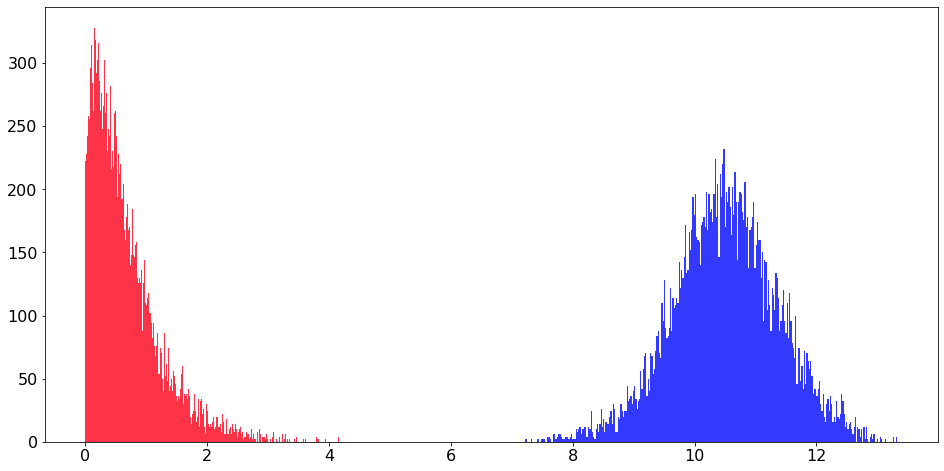

In [5]:
num_emb_neurons = xp1.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class_nolinear, num_emb_neurons, xp1.trainer.config_class.modo)

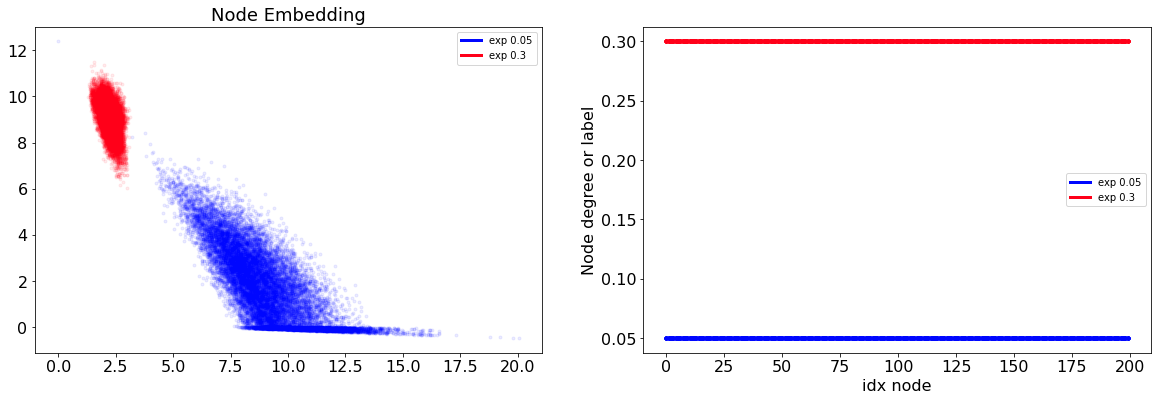

In [5]:
plot_node_emb_nD_perclass(embedding_class_nolinear.emb_perclass)

In [25]:
graembc1 = np.array([embpergraph.graph_embedding for embpergraph in embedding_class1.emb_perclass[0]])

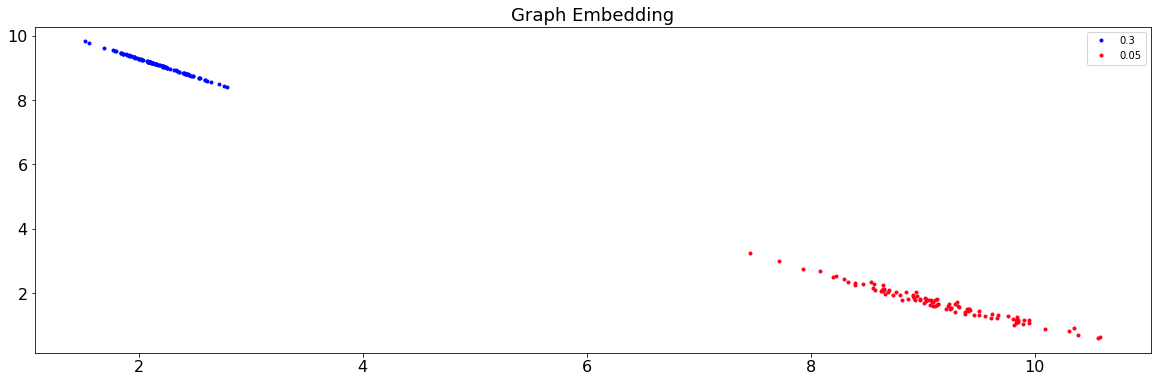

In [6]:
plot_graph_emb_3D(embedding_class_nolinear.emb_perclass)

In [7]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class_nolinear.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class_nolinear.emb_perclass[1]])
nodeembc2 = nodeembc2.squeeze()
nodeembc1 = nodeembc1.squeeze()
print(nodeembc1.shape, nodeembc2.shape)
nodeembc1 = nodeembc1.reshape(-1,2)
nodeembc2 = nodeembc2.reshape(-1,2)
print(nodeembc1.shape, nodeembc2.shape)

(100, 200, 2) (100, 200, 2)
(20000, 2) (20000, 2)


In [8]:
np.save('nodeembc1_nolinear.npy', nodeembc1)
np.save('nodeembc2_nolinear.npy', nodeembc2)

#### CLustering - uso HDBSCAN con score di clustering ***calinski_harabasz_score***

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [16]:
embs = np.concatenate((nodeembc1, nodeembc2))
embs.shape

(40000, 2)

Text(0, 0.5, 'eps')

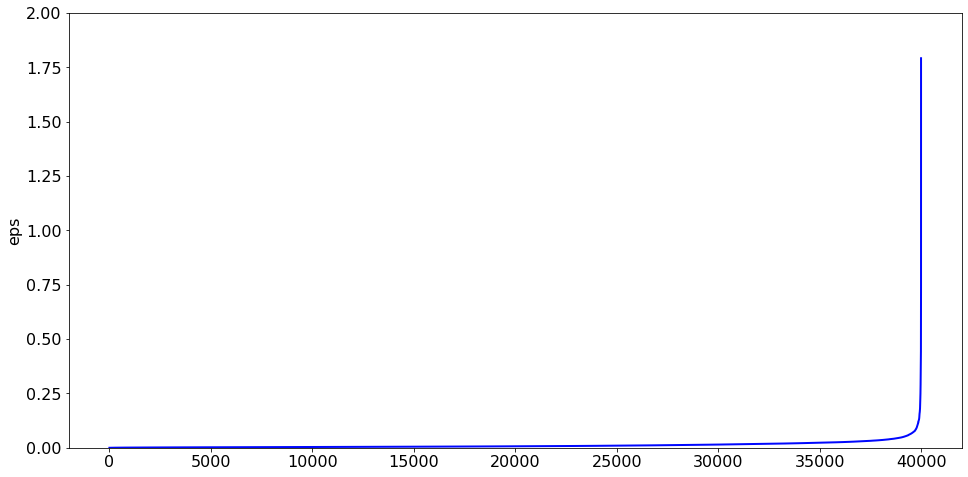

In [20]:
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors_fit = neighbors.fit(embs)
distances, indices = neighbors_fit.kneighbors(embs)

distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.ylim(0, 2)
plt.plot(distances)
plt.ylabel('eps')

In [21]:
def k_distances2(x, k):
    """ Function to calculate distance of each point to its k-th NN 
        x: dataset
        k: #NN
    """
    
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p = -2*x.dot(x.T) + np.sum(x**2, axis = 1).T + np.repeat(np.sum(x**2, axis = 1),dim0, axis = 0).reshape(dim0,dim0)
    p = np.sqrt(p) #EUCLIDEAN DISTANCE
    p.sort(axis = 1)
    p = p[:,:k]
    pm = np.sort(p.flatten())
    
    return p, pm

m, m2 = k_distances2(embs, 20)

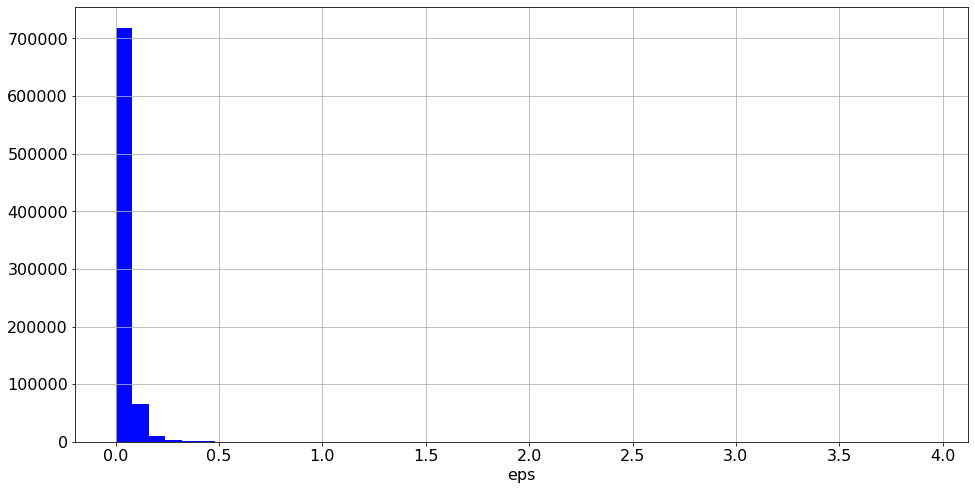

In [26]:
plt.hist(m2, bins = 49)
plt.xlabel('eps') #epsilon distance
plt.grid(True)

In [27]:
y_pred = DBSCAN(eps = 0.5, min_samples = 20).fit_predict(embs)
#db = DBSCAN(eps = 0.3, min_samples = 20).fit(X)
#labels = db.labels_

In [29]:
# cluster diversi trovati - al rumore viene assegnato il valore -1
set(y_pred[np.where(y_pred != -1)])

{0, 1}

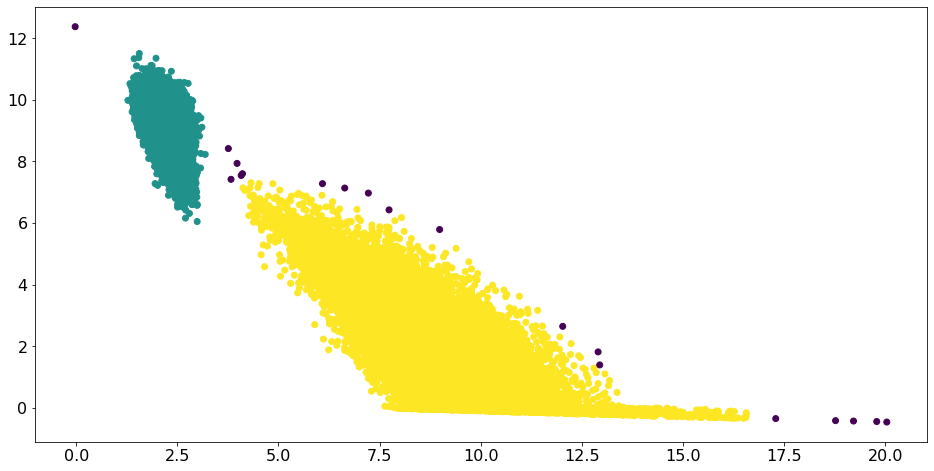

In [28]:
plt.scatter(*embs.T, c = y_pred)

In [16]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score

In [31]:
calinski_harabasz_score(embs, y_pred)

162031.055115696

In [34]:
silhouette_score(embs, y_pred)

0.758773

#### PErturbo il dataset

In [ ]:
xp1.trainer.gg.perturb_dataset(125, verbose=False)

In [11]:
init_weigths_method = xp1.trainer.config_class.init_weights_mode
w = new_parameters(xp1.trainer.init_GCN(), init_weigths_method)
model = xp1.trainer.init_GCN(init_weights_gcn=w)
xp1.trainer.load_model(model)
xp1.trainer.launch_training()
embedding_class_nolinear = xp1.embedding()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:34<00:00, 23.06it/s]

test accuracy finale: 1.0


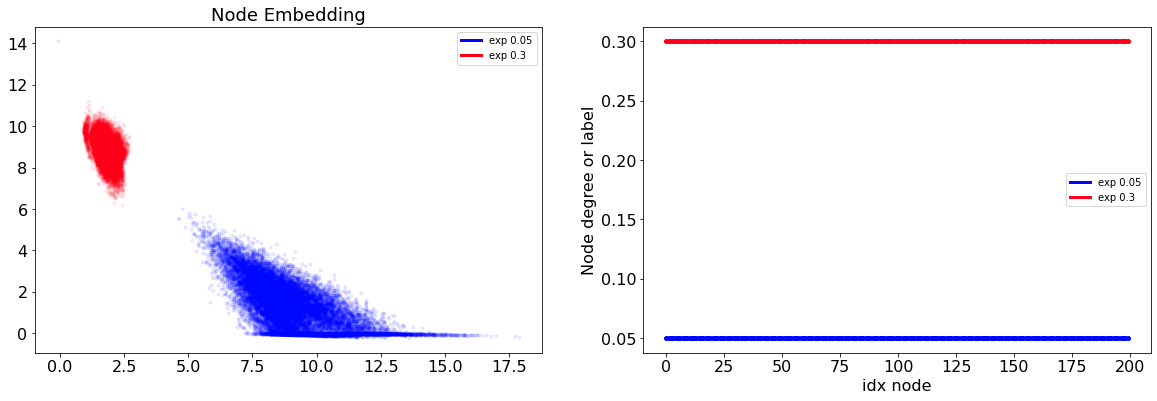

In [12]:
plot_node_emb_nD_perclass(embedding_class_nolinear.emb_perclass)

(100, 200, 2) (100, 200, 2)
(20000, 2) (20000, 2)


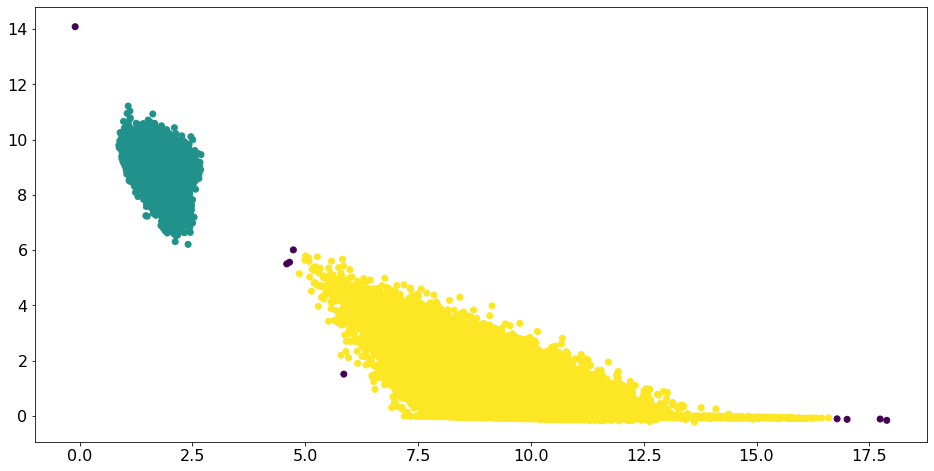

In [15]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class_nolinear.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class_nolinear.emb_perclass[1]])
nodeembc2 = nodeembc2.squeeze()
nodeembc1 = nodeembc1.squeeze()
print(nodeembc1.shape, nodeembc2.shape)
nodeembc1 = nodeembc1.reshape(-1,2)
nodeembc2 = nodeembc2.reshape(-1,2)
print(nodeembc1.shape, nodeembc2.shape)

embs = np.concatenate((nodeembc1, nodeembc2))
embs.shape

y_pred = DBSCAN(eps = 0.5, min_samples = 20).fit_predict(embs)
plt.scatter(*embs.T, c = y_pred)

In [17]:
calinski_harabasz_score(embs, y_pred)

252026.67068920657

In [18]:
silhouette_score(embs, y_pred)

0.81129616

### Lascio i linear layer finali

In [45]:
xp1 = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp1.just_train()
embedding_class1 = xp1.embedding()

Generating dataset...
Mean connectivity for each node: 9.955 p=0.05
Mean connectivity for each node: 59.707 p=0.3
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.55it/s]


Tempo impiegato: 6.569103002548218


100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:37<00:00, 21.16it/s]

test accuracy finale: 1.0


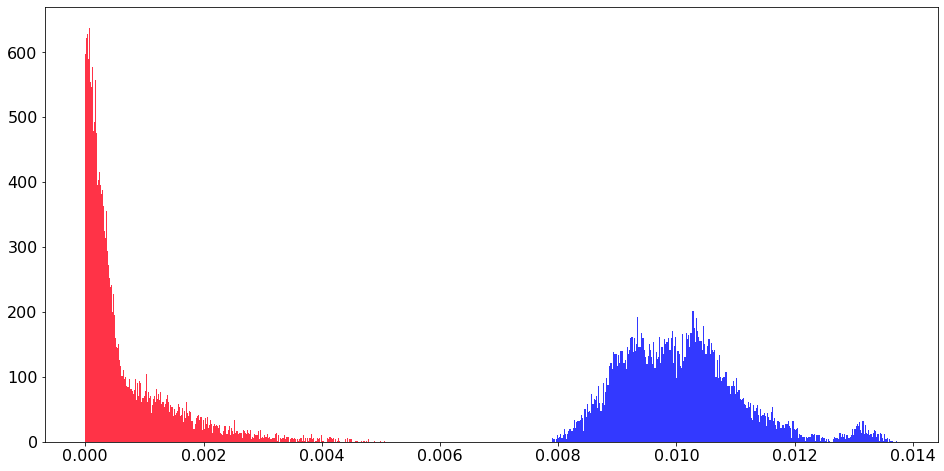

In [46]:
num_emb_neurons = xp1.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class1, num_emb_neurons, xp1.trainer.config_class.modo)

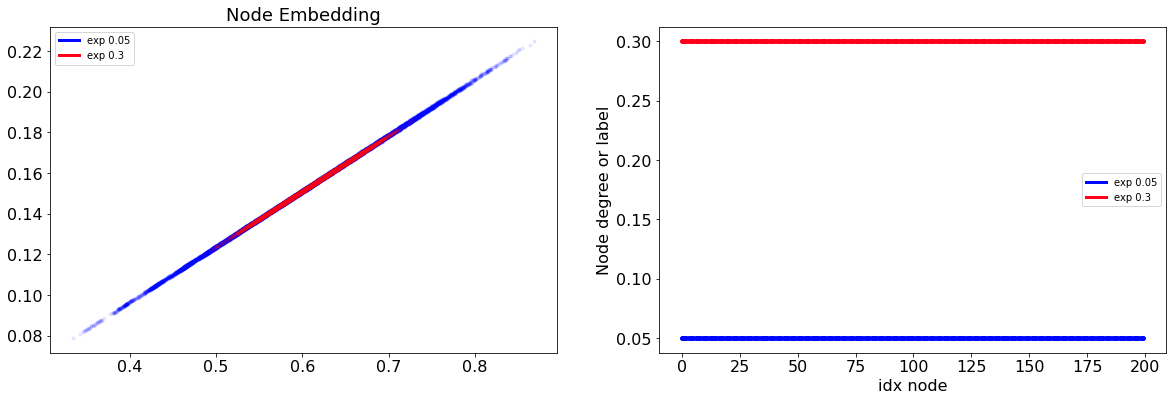

In [47]:
plot_node_emb_nD_perclass(embedding_class1.emb_perclass)

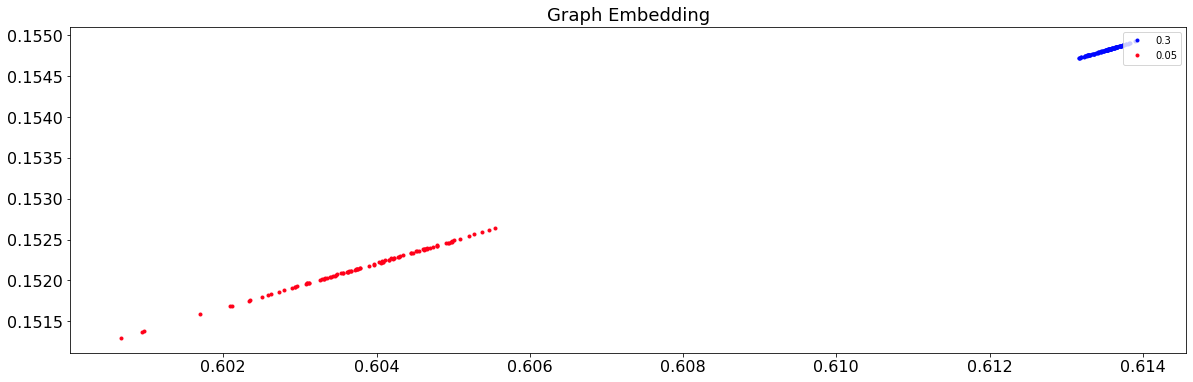

In [48]:
plot_graph_emb_3D(embedding_class1.emb_perclass)

In [54]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class1.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class1.emb_perclass[1]])
nodeembc2 = nodeembc2.squeeze()
nodeembc1 = nodeembc1.squeeze()
print(nodeembc1.shape, nodeembc2.shape)
nodeembc1 = nodeembc1.reshape(-1,2)
nodeembc2 = nodeembc2.reshape(-1,2)
print(nodeembc1.shape, nodeembc2.shape)

(100, 200, 2) (100, 200, 2)
(20000, 2) (20000, 2)


In [55]:
np.save('nodeembc1.npy', nodeembc1)
np.save('nodeembc2.npy', nodeembc2)

### GCN freezed

In [15]:
c = Config(config_file)
c.conf['model']['freezeGCNlayers'] = True
xp2 = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp2.just_train()
embedding_class2 = xp2.embedding()

Generating dataset...
Mean connectivity for each node: 9.955 p=0.05
Mean connectivity for each node: 79.57 p=0.4
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.43it/s]


Tempo impiegato: 8.210928678512573


100%|█████████████████████████████████████████████████████████| 800/800 [00:42<00:00, 18.69it/s]


test accuracy finale: 1.0


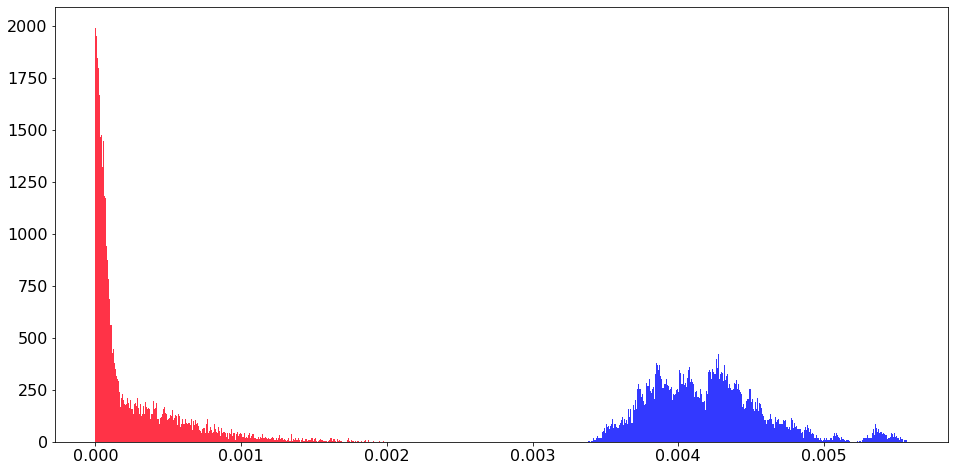

In [64]:
num_emb_neurons = xp2.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class2, num_emb_neurons, xp2.trainer.config_class.modo)

In [38]:
len(embedding_class.emb_perclass[0])#[0]#.node_embedding_array

100

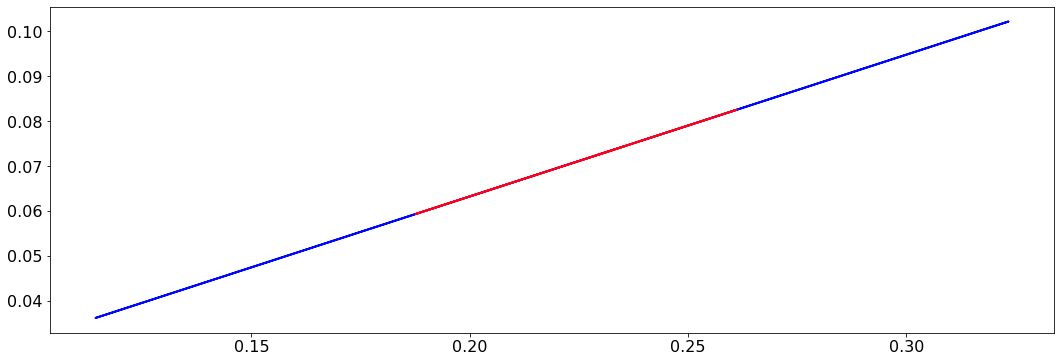

In [82]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[1]])
nodeembc1 = np.array(nodeembc1).transpose(2,0,1)
nodeembc2 = np.array(nodeembc2).transpose(2,0,1)
plt.figure(figsize=(18, 6))
plt.plot(nodeembc2[0].flatten(), nodeembc2[1].flatten())#, s=0.3, marker='.', color='blue');
plt.plot(nodeembc1[0].flatten(), nodeembc1[1].flatten())#, s=0.3, marker='.', color='red');
plt.show()